# Modelo preentrenado sin Data Augmentation

En este notebook, se muestra como hemos realizado fine tuning a un modelo preentrenado llamado Xception.

El dataset utilizado para reentrenar este modelo es el Garbage Classification, que podemos encontrar en [Kaggle](https://www.kaggle.com/datasets/mostafaabla/garbage-classification). 

En este caso, no aplicaremos ningun tipo de augmentation ni preprocesado a las imagenes, simplemente añadiremos algunas capas adicionales al modelo para realizar fine tunning durante el entrenamiento del modelo.

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
# from keras.layers.experimental.preprocessing import Normalization
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc


c:\Users\marti\anaconda3\envs\ml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


En primer lugar, definimos todas las constantes que vamos a utilizar en el notebook.

En esta celda, se crea un diccionario que contiene las categorías de las 12 clases de basura en las que está dividido nuestro dataset. En este caso, como vamos a utilizar el dataset original, todos los datos están en el mismo directorio y deberemos hacer la particion con el método train_test_split de sklearn.

In [4]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 320    
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


En la siguiente celda almacenamos los paths de todas las imagenes que hay en nuestro dataset, con su correspondiente clase, y los almacenamos en un dataframe que más tarde será el que utilizaremos para inicializar los generators.

In [5]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df
    
base_path = "garbage_classification/"

# lista para guardar los nombres de los archivos
filenames_list = []

# lista para guardar las categorías
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [6]:
# Comprobamos que se ha cargado correctamente
df.head()

filename  category
0              shoes/shoes192.jpg         6
1               metal/metal71.jpg         3
2         clothes/clothes1758.jpg         7
3         clothes/clothes4882.jpg         7
4  brown-glass/brown-glass138.jpg         9

A continuación vamos a cargar una de las imagenes contenidas en el set de entrenamiento, para observar un ejemplo. Cada vez que ejecutemos esta celda, estaremos cargando una imagen distinta.

In [7]:
# Visualizacion de una imagen de una clase aleatoria dentro del set de entrenamiento
from tensorflow.keras.preprocessing import image

random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

shoes/shoes1490.jpg


En la siguiente celda podemos ver la distribucion de las clases en el dataset original. Como se puede observar, el dataset está muy desbalanceado, como ya hemos visto en notebooks anteriores. En este caso, no vamos a modificar nada, utilizaremos el dataset original para entrenar nuestro modelo. Solamente tendremos que tener cuidado a la hora de separar los datos en los tres conjuntos de train, validacion y test para asegurarnos de que todas las clases entren en todos los conjuntos y poder realizar correctamente las pruebas.

In [8]:
df_visualization = df.copy()

# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

Una vez cargados los datos y habiendo hecho un pequeño análisis de la distribucion de las clases, podemos pasar a la parte del modelo. 

En esta celda, estamos cargando nuestro modelo preentrenado, sin incluir el top, de esta forma estamos eliminando su clasificador original, para sustituirlo por uno nuevo que generemos nosotros a partir de nuestros datos. Además del clasificador, añadiremo unas capas adicionales, que servirán para extraer nuevas características. 

Además, le indicamos al modelo que los pesos de la red original deben estar congelados, de esta forma aprovechamos el conocimiento que la red ya tiene, y simplemente debemos ajustarlo a nuestro problema.

Utilizaremos las imagenes de entrada con el tamaño que indicamos anteriormente en este mismo notebook a la hora de definir las constantes. Es un tamaño considerable, así, al hacer pooling durante el entrenamiento, seguiremos teniendo suficiente informacion para poder extraer features relevantes.

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.xception as xception

xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), 
                                   weights = 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

# We don't want to train the imported weights
xception_layer.trainable = False

model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
    return xception.preprocess_input(img)

# Añadimos la red preentrenada
model.add(Lambda(xception_preprocessing))
model.add(xception_layer)

# Añadimos más capas para fine tuning
tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, input_shape=(150, 150, 3), padding='same'),
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Hacemos un flatten para poder meterlo en una red densa
model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(len(categories),kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 320, 320, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 2048)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 51200)            204800    
 hNormalization)                                        

En esta celda vamos a dividir el set de datos en los conjutnos de train, test y validacion. Como hemos comentado antes, utilizamos el parámetro stratify para que incluya todas las clases en todos los conjuntos de datos. 

En esta celda comprobamos además el tamaño de cada uno de los conjuntos.

In [10]:
# Cambiamos el valor de la categoría por el nombre de la categoría
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['category'])
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42, stratify=validate_df['category'])

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_train)
print('validate size = ', total_validate)
print('test size = ', test_df.shape[0])

train size =  12412
validate size =  1551
test size =  1552


In [11]:
# Comprobamos que el numero de clases son las mismas en los tres sets
print("Categorias train: ", len(train_df.value_counts('category')))
print("Categorias val: ", len(validate_df.value_counts('category')))
print("Categorias test: ", len(test_df.value_counts('category')))

Categorias train:  12
Categorias val:  12
Categorias test:  12


Inicializamos los generators de train y validacion con los dataframes que hemos definido anteriormente. Como indicamos, mantendremos el tamaño de la imagen con el valor que contiene la constante IMAGE_SIZE, es decir 320x320.

In [12]:
batch_size=64

train_datagen = image.ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [13]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 1551 validated image filenames belonging to 12 classes.


Definimos un checkpoint que se ejecutará cada época de entrenamiento, de esta forma se guardará una version del modelo en cada iteracion, de forma que si en algun momento empiezan a empeorar los resultados por sobreentrenamiento, siempre tendremos las versiones anteriores para poder volver a ellas.

In [14]:
checkpoint_path = "checkpoints/saved-model_SinAug-{epoch:02d}.hdf5"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    save_freq='epoch'
)

En esta celda se entrena el modelo. Hemos indicado un periodo de 10 épocas para ser capaces de ver mejoras en el entrenamiento.

Como se puede ver, el modelo es bastante bueno desde el principio del entrenamiento, consiguiendo un accuracy del 90% en validacion desde la primera época. A medida que van aumentando las épocas, mejoran tanto el accuracy de entrenamiento como el de validacion, lo que nos da a entender que el modelo no se está sobreentrenando. Durante las 10 épocas de entrenamiento no deja de aprender en ningún momento, lo que nos indica que si hubiésemos entrenado el modelo durante más épocas, habríamos conseguido mejorar aún más el accuracy de ambos sets de datos.

In [56]:
EPOCHS = 10
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[checkpoint]
)

Epoch 1/10
193/193 [==============================] - 1038s 5s/step - loss: 1.2368 - categorical_accuracy: 0.7009 - val_loss: 0.7779 - val_categorical_accuracy: 0.9023
Epoch 2/10
193/193 [==============================] - 1006s 5s/step - loss: 0.6580 - categorical_accuracy: 0.8524 - val_loss: 0.3822 - val_categorical_accuracy: 0.9355
Epoch 3/10
193/193 [==============================] - 1036s 5s/step - loss: 0.4337 - categorical_accuracy: 0.8950 - val_loss: 0.2850 - val_categorical_accuracy: 0.9395
Epoch 4/10
193/193 [==============================] - 1191s 6s/step - loss: 0.3357 - categorical_accuracy: 0.9149 - val_loss: 0.2200 - val_categorical_accuracy: 0.9414
Epoch 5/10
193/193 [==============================] - 1148s 6s/step - loss: 0.2622 - categorical_accuracy: 0.9321 - val_loss: 0.2046 - val_categorical_accuracy: 0.9440
Epoch 6/10
193/193 [==============================] - 1165s 6s/step - loss: 0.2261 - categorical_accuracy: 0.9384 - val_loss: 0.1871 - val_categorical_accuracy:

In [24]:
# Guardamos el modelo final para poder usarlo en el futuro
model.load_weights("checkpoints/saved-model_SinAug-10.hdf5")

Creamos el Generator del conjunto de datos de test para utilizarlo para realizar las predicciones con el modelo recien entrenado.

In [40]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1552 validated image filenames belonging to 12 classes.


Como podemos ver, obtenemos unaccuracy en test de un 99%, lo cual nos indica que es muy buen modelo.

In [41]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)
print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

C:\Users\marti\AppData\Local\Temp\ipykernel_16952\2155452081.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


accuracy on test set =  99.1 % 


In [60]:
# Definimos al principio de este notebook un diccionario que mapea el número de categorías a nombres, pero el generador de entrenamiento
# generó su propio diccionario y ha asignado diferentes números a nuestras categorías y las predicciones hechas por el modelo 
# se harán usando el diccionario del generador.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


En la siguiente celda se pueden ver algunas métricas en funcion de la clase que esté tratando de predecir el modelo. Podemos ver que para todas las clases, las métricas son buenísimas. Además, como no hemos hecho balanceo de clases y la clase clothes aparecía mucho más que el resto de clases, podemos ver que hemos llegado a obtener un accuracy del 100% en el conjunto de set, lo cual nos indica que hemos conseguido un muy buen modelo.

In [61]:
#  obtener las predicciones del modelo para el conjunto de pruebas
preds = model.predict_generator(test_generator, nb_samples)

# Obtener la categoría con la mayor probabilidad predicha, la predicción es sólo el número de la categoría y no el nombre
preds = preds.argmax(1)

# Convierte el número de la categoría prevista en nombre
preds = [gen_label_map[item] for item in preds]

# Convertir el df en una matriz numpy
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

C:\Users\marti\AppData\Local\Temp\ipykernel_3484\727984934.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     battery       0.98      0.96      0.97        95
  biological       0.96      1.00      0.98        99
 brown-glass       0.75      0.89      0.81        61
   cardboard       0.97      0.93      0.95        89
     clothes       1.00      0.99      0.99       533
 green-glass       0.88      0.67      0.76        63
       metal       0.90      0.79      0.84        77
       paper       0.89      0.92      0.91       105
     plastic       0.84      0.91      0.87        86
       shoes       0.94      0.99      0.97       198
       trash       0.97      0.96      0.96        69
 white-glass       0.87      0.86      0.86        77

    accuracy                           0.94      1552
   macro avg       0.91      0.90      0.91      1552
weighted avg       0.94      0.94      0.94      1552



In [43]:
# Realizamos las predicciones sobre el conjunto de test
y_pred = model.predict(test_generator, steps=len(test_generator))

1552/1552 [==============================] - 545s 348ms/step


In [44]:
# Obtener etiquetas actuales de los datos de prueba
y_test_classes = test_generator.classes
y_test_labels = test_generator.labels

A continuación se puede ver la matriz de confusion.

Como se puede ver, hemos conseguido que la mayoría de valores estén en la diagonal principal de la matriz, lo que nos indica que el modelo está prediciendo bien la mayoría de las clases. 

In [45]:

# Calculate the confusion matrix
cm = confusion_matrix(test_generator.classes, np.argmax(y_pred, axis=1))

# Convert counts to percentages
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_perc = cm
# Plot the confusion matrix
plt.figure(figsize=(8, 8))
im = plt.imshow(cm_perc, cmap=plt.cm.Blues)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix (% percentages)")
plt.colorbar(im)

# Annotate each cell with its value
thresh = cm_perc.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.0f'),
                 horizontalalignment="center",
                 color="white" if cm_perc[i, j] > thresh else "black")
plt.xticks(np.arange(12), categories.values(), rotation=45)
plt.yticks(np.arange(12), categories.values(), rotation=0)

plt.tight_layout()
plt.show()

Por último, generamos la curva roc con las predicciones del conjunto de test.

Como se puede ver,  hemos conseguido un AUC de un 1, lo cual nos indica que es es un modelo perfectamente ajustado a nuestros datos, con la capacidad suficiente para generalizar. 

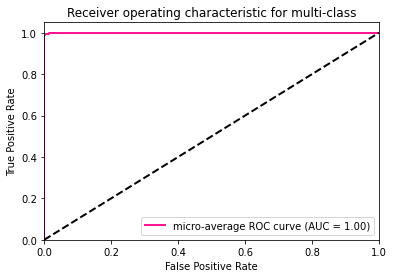

In [48]:
y_test = keras.utils.to_categorical(y_test_labels, len(categories))
# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute the micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves for each class and the micro-average
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='deeppink',
         lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
                ''.format(roc_auc["micro"]))
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray', 'olive', 'cyan', 'magenta', 'black']
# for i, color in zip(range(len(categories)), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (AUC = {1:0.2f})'
#              ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")

plt.show()